<a href="https://colab.research.google.com/github/jaredmccain-ux/pytorch-tutorial-learning-notes/blob/main/_downloads/36608d2d57f623ba3a623e0c947a8c3e/data_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\|
[Quickstart](quickstart_tutorial.html) \|\|
[Tensors](tensorqs_tutorial.html) \|\| **Datasets & DataLoaders** \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Datasets & DataLoaders
======================


Code for processing data samples can get messy and hard to maintain; we
ideally want our dataset code to be decoupled from our model training
code for better readability and modularity. PyTorch provides two data
primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`
that allow you to use pre-loaded datasets as well as your own data.
`Dataset` stores the samples and their corresponding labels, and
`DataLoader` wraps an iterable around the `Dataset` to enable easy
access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such
as FashionMNIST) that subclass `torch.utils.data.Dataset` and implement
functions specific to the particular data. They can be used to prototype
and benchmark your model. You can find them here: [Image
Datasets](https://pytorch.org/vision/stable/datasets.html), [Text
Datasets](https://pytorch.org/text/stable/datasets.html), and [Audio
Datasets](https://pytorch.org/audio/stable/datasets.html)


Loading a Dataset
=================

Here is an example of how to load the
[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/)
dataset from TorchVision. Fashion-MNIST is a dataset of Zalando's
article images consisting of 60,000 training examples and 10,000 test
examples. Each example comprises a 28×28 grayscale image and an
associated label from one of 10 classes.

We load the [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) with the following parameters:

:   -   `root` is the path where the train/test data is stored,
    -   `train` specifies training or test dataset,
    -   `download=True` downloads the data from the internet if it\'s
        not available at `root`.
    -   `transform` and `target_transform` specify the feature and label
        transformations


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.98MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]


Iterating and Visualizing the Dataset
=====================================

We can index `Datasets` manually like a list: `training_data[index]`. We
use `matplotlib` to visualize some samples in our training data.


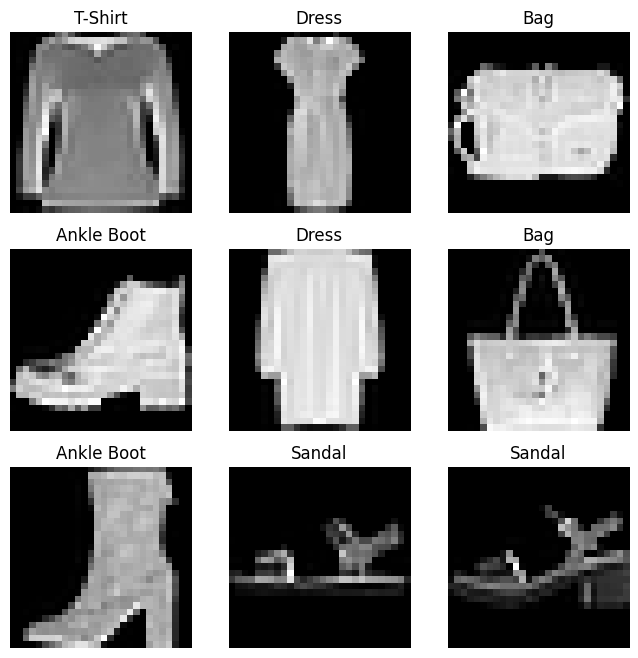

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

------------------------------------------------------------------------


Creating a Custom Dataset for your files
========================================

A custom Dataset class must implement three functions:
[\_\_init\_\_]{.title-ref}, [\_\_len\_\_]{.title-ref}, and
[\_\_getitem\_\_]{.title-ref}. Take a look at this implementation; the
FashionMNIST images are stored in a directory `img_dir`, and their
labels are stored separately in a CSV file `annotations_file`.

In the next sections, we\'ll break down what\'s happening in each of
these functions.


In [6]:
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

`__init__`
==========

The \_\_[init](#init__) function is run once when instantiating the
Dataset object. We initialize the directory containing the images, the
annotations file, and both transforms (covered in more detail in the
next section).

The labels.csv file looks like: :

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9


In [9]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

`__len__`
=========

The \_\_[len](#len__) function returns the number of samples in our
dataset.

Example:


In [8]:
def __len__(self):
    return len(self.img_labels)

`__getitem__`
=============

The \_\_[getitem](#getitem__) function loads and returns a sample from
the dataset at the given index `idx`. Based on the index, it identifies
the image\'s location on disk, converts that to a tensor using
`decode_image`, retrieves the corresponding label from the csv data in
`self.img_labels`, calls the transform functions on them (if
applicable), and returns the tensor image and corresponding label in a
tuple.


# **解释iloc:**

当你看到 `self.img_labels.iloc` 时，这说明你的 `img_labels` 变量是一个 **Pandas DataFrame**（类似于 Python 里的 Excel 表格）。

`iloc` 的全称是 **integer-location**。简单来说，它的作用是：**通过“行号”和“列号”来精准提取数据。**

---

### 1. 为什么要用它？

在 PyTorch 的 `Dataset` 类中，`__getitem__(self, idx)` 方法会传入一个整数 `idx`（索引）。由于 Pandas 的表格可能经过排序、筛选，它的“标签”（Label）可能会乱掉（比如第一行的标签变成了 102 ），但它的“行号”（Position）永远是从 0 开始的。

**`iloc` 保证你拿到的永远是第 `idx` 行，而不是标签名为 `idx` 的那一行。**

---

### 2. 语法规则

`iloc` 的基本语法是：`iloc[行索引, 列索引]`。

假设你的 CSV 文件长这样：
| | file_name | label |
| :--- | :--- | :--- |
| 0 | snake.jpg | 3 |
| 1 | apple.jpg | 5 |

#### 常用写法：

* **`df.iloc[0]`**：取出第 0 行的所有数据。
* **`df.iloc[0, 1]`**：取出第 0 行、第 1 列的数据（即标签 `3`）。
* **`df.iloc[:, 0]`**：取出所有行的第 0 列（即所有文件名）。

---

### 3. 在 PyTorch Dataset 中的经典用法

在你提到的场景里，代码通常长这样：

```python
def __getitem__(self, idx):
    # 使用 .iloc[idx, 0] 准确拿到第 idx 行的图片路径（第 0 列）
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    
    # 使用 .iloc[idx, 1] 准确拿到第 idx 行的标签（第 1 列）
    label = self.img_labels.iloc[idx, 1]
    
    # ... 之后加载图片并返回
    return image, label

```

---

### 4. 易混淆点：`iloc` vs `loc`

这是很多初学者会踩的坑：

* **`iloc` (integer-location)**：只认**数字编号**。`iloc[0]` 永远是第一行。
* **`loc` (location)**：认**标签名**。如果你的表格索引（Index）是字符串或者打乱的数字，`loc[0]` 可能会报错或者找错行。

> **比喻：**
> 想象一排学生。
> `iloc[0]` 说的是：“请**坐在第一位的那个同学**站起来。”（不管他是谁）
> `loc[0]` 说的是：“请**工号是 0 的那个同学**站起来。”（不管他坐在哪）

---

### 总结

在处理数据集时，使用 `iloc` 是最安全的做法，因为它能确保 PyTorch 传入的索引（0, 1, 2...）能准确对应到表格的每一行。

你现在的代码里，`img_labels` 是通过 `pd.read_csv` 加载进来的吗？如果是的话，我可以帮你写一个更完整的 `__getitem__` 示例。

In [7]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = decode_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

------------------------------------------------------------------------


Preparing your data for training with DataLoaders
=================================================

The `Dataset` retrieves our dataset\'s features and labels one sample at
a time. While training a model, we typically want to pass samples in
\"minibatches\", reshuffle the data at every epoch to reduce model
overfitting, and use Python\'s `multiprocessing` to speed up data
retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an
easy API.


In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterate through the DataLoader
==============================

We have loaded that dataset into the `DataLoader` and can iterate
through the dataset as needed. Each iteration below returns a batch of
`train_features` and `train_labels` (containing `batch_size=64` features
and labels respectively). Because we specified `shuffle=True`, after we
iterate over all batches the data is shuffled (for finer-grained control
over the data loading order, take a look at
[Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).


# **解释sequeeze**
简单来说，`squeeze()` 的作用是**“降维”**。它会把 Tensor 中所有长度为 **1** 的维度全部删掉，就像把一个“扁平”的维度给挤压掉一样。

---

### 1. 为什么要在这里用 `squeeze()`？

在你的代码里，`train_features[0]` 通常是一个形状为 **** 的 Tensor（代表：通道数 ，高度 ，宽度 ）。

如果你想用 `matplotlib` 把这张图画出来，问题就来了：

* **PyTorch 的格式**：  
* **Matplotlib 的要求**：对于灰度图，它只接受   

如果你直接把  传给 `plt.imshow()`，它会因为多了那个  而报错。
**`squeeze()` 的作用就是把那个多余的  挤掉，让形状变成 。**

---

### 2. 直观的例子

假设你有一个 Tensor `x`：

```python
import torch

# 假设 x 的形状是 [1, 28, 28]
x = torch.zeros([1, 28, 28])
print(x.shape) # 输出: torch.Size([1, 28, 28])

# 使用 squeeze()
y = x.squeeze()
print(y.shape) # 输出: torch.Size([28, 28])  <-- 那个 1 消失了！

```

### 3. 注意点：它只挤压长度为 1 的维度

如果某个维度的大小不是 1（比如是 3），`squeeze()` 是**挤不动**它的。

* 形状  （成功挤掉了第 0 维）
* 形状  （毫无变化，因为没有长度为 1 的维度）

---

### 4. 进阶用法：指定维度

有时候你只想挤掉特定的某一个维度，可以传参数：

* `x.squeeze(0)`：只尝试挤掉第 0 维（如果它是 1 的话）。
* `x.squeeze(1)`：只尝试挤掉第 1 维。

---

### 5. 举一反三：`unsqueeze()`

既然有“挤压”，就有“扩张”。`unsqueeze(dim)` 的作用是在指定位置**增加**一个长度为 1 的维度。

* **场景**：你的模型需要输入一组图片（Batch），形状是 。但你现在手头只有一张图 。
* **操作**：`img.unsqueeze(0)` 会让形状变成 ，这样模型就能认出“这是一个 Batch 大小为 1 的数据”了。

---

### 总结对照表

| 函数 | 动作 | 结果示例 |
| --- | --- | --- |
| **`squeeze()`** | 删掉所有长度为 1 的维度 |  |
| **`unsqueeze(0)`** | 在第 0 维新增一个维度 |  |

**想知道怎么在画图时同时改变颜色映射（比如把黑白图变成彩色显示的“热力图”）吗？**

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


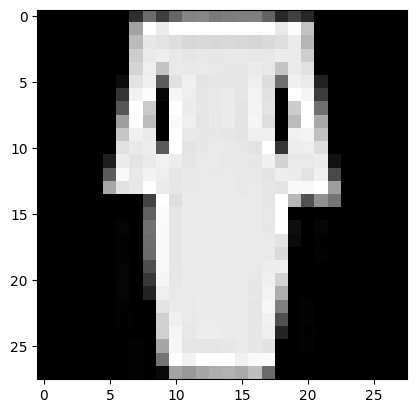

Label: 3


In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

------------------------------------------------------------------------


Further Reading
===============

-   [torch.utils.data API](https://pytorch.org/docs/stable/data.html)
